#  Capstone Project of Group 1 of the DTU Data Science course 2020

## Notebook 2: Annreg MLPregression model

### Exercise description: 
A dataset was given with data obtained from the open data website edp.com and the task was given to create a prediction model for the power forecast based on the provided data.

### Project participants: 
Alessandro Sebastiani <aseb@dtu.dk>; Leonardo Andrès Alcayaga Romàn <lalc@dtu.dk>; Moritz Wegener <mbgw@kth.se>

### Work packages:

1. Insert and inspect data (Notebook 1)

2. Create a persistence model/reference model (Notebook 1)    
    
3. Annreg MLPregression model: Sklearn (Notebook 2)

4. Use uniivariate machine learning: GRU, LSTM
       
5. Use multivariate machine learning: GRU, LSTM
  
6. Results comparison






This notebook is structured as follows:

1. Data preparation

2. Model tests witk ANNreg MLPRegressor
    1. Raw data vs. ffilled
    2. Only wind as input vs. Wind + Power
    3. Different sizes of layers and neurons
    
3. Prediction model with ANNreg MLPRegressor

Conclusions

##  <span style="color:blue">1. Insert, inspect, and prepare data

1. Load python packages
2. Read in dataset
3. Set date and time for data set
4. Plot power curve of all turbines


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import pytz
from datetime import datetime
import os


current_path = os.getcwd()
print(current_path )

C:\Users\mbgw\Desktop\Data Science


In [2]:
import numpy as np
import sklearn
import sklearn.neural_network
import sklearn.ensemble #Random forest
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [3]:
# Read in data set 
dataset = pd.read_csv('DataScienceCourse_EDPdata.csv', 
                  sep=';')


#Remove excess timestamp data
dataset.Timestamp = dataset.Timestamp.str.replace('\+00:00', '')

In [4]:
#Use panda function to set datatime as index
dataset.Timestamp = pd.to_datetime(dataset.Timestamp )
dataset.set_index('Timestamp', inplace=True)

In [5]:
# Select variables to be used for further analysis with dataset_ch and localize timezone for dataset_ch
channels= ['Turbine_ID',
           'Gen_RPM_Avg', 'Gen_RPM_Std', 'Gen_RPM_Max', 'Gen_RPM_Min',
           'Rtr_RPM_Avg', 'Rtr_RPM_Std', 'Rtr_RPM_Max', 'Rtr_RPM_Min', 
           'Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std', 'Amb_WindSpeed_Max','Amb_WindSpeed_Min', 
           'Amb_WindDir_Relative_Avg', 'Amb_WindDir_Abs_Avg',
           'Amb_Temp_Avg',
           'Blds_PitchAngle_Avg', 'Blds_PitchAngle_Std','Blds_PitchAngle_Max','Blds_PitchAngle_Min',
           'Grd_Prod_Pwr_Avg', 'Grd_Prod_Pwr_Std', 'Grd_Prod_Pwr_Max', 'Grd_Prod_Pwr_Min',
           'Amb_WindSpeed_Est_Avg',
           'Nac_Direction_Avg',
           'Status_Flag']
dataset_ch = dataset[channels].copy()
dataset_ch.tz_localize('UTC')
dataset_ch.sort_index(inplace=True)


In [6]:
#Create new array with turbine IDs
turbinesid = dataset_ch.Turbine_ID.unique()
turbinesid

array(['T09', 'T06', 'T01', 'T07', 'T11'], dtype=object)

In [7]:
## Create dataset for each turbine
            # Maybe this could be done with a dictionary, but I could not figure out how
df_T01 = dataset_ch[:][dataset_ch.Turbine_ID == 'T01']
df_T06 = dataset_ch[:][dataset_ch.Turbine_ID == 'T06']
df_T07 = dataset_ch[:][dataset_ch.Turbine_ID == 'T07']
df_T09 = dataset_ch[:][dataset_ch.Turbine_ID == 'T09']
df_T11 = dataset_ch[:][dataset_ch.Turbine_ID == 'T11']


#There is some data with the same timesteps (one hour, probably due to summer/winter change, too lazy too look up how to get rid of it in a better way)
df_T01 = df_T01[~df_T01.index.duplicated()]   
df_T06 = df_T06[~df_T06.index.duplicated()]   
df_T07 = df_T07[~df_T07.index.duplicated()]   
df_T09 = df_T09[~df_T09.index.duplicated()]   
df_T11 = df_T11[~df_T11.index.duplicated()]   

In [8]:
#Resample each turbine data set
df_T01_sampled = df_T01.resample('10 min').asfreq()
df_T06_sampled = df_T06.resample('10 min').asfreq()
df_T07_sampled = df_T07.resample('10 min').asfreq()
df_T09_sampled = df_T09.resample('10 min').asfreq()
df_T11_sampled = df_T11.resample('10 min').asfreq()

df_T01_sampled

,Turbine_ID,Gen_RPM_Avg,Gen_RPM_Std,Gen_RPM_Max,Gen_RPM_Min,Rtr_RPM_Avg,Rtr_RPM_Std,Rtr_RPM_Max,Rtr_RPM_Min,Amb_WindSpeed_Avg,...,Blds_PitchAngle_Std,Blds_PitchAngle_Max,Blds_PitchAngle_Min,Grd_Prod_Pwr_Avg,Grd_Prod_Pwr_Std,Grd_Prod_Pwr_Max,Grd_Prod_Pwr_Min,Amb_WindSpeed_Est_Avg,Nac_Direction_Avg,Status_Flag
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,T01,1249.0,9.0,1277.4,1226.1,11.1,0.1,11.3,10.9,3.3,...,0.9,4.5,-1.1,26.2,35.3,118.4,-33.5,3.6,218.5,1.0
2016-01-01 00:10:00,T01,999.7,435.9,1268.3,93.3,8.8,4.0,11.2,0.0,3.2,...,14.7,59.6,-0.9,10.1,30.2,101.5,-38.2,3.3,218.5,1.0
2016-01-01 00:20:00,T01,774.0,486.1,1394.4,220.3,6.8,4.3,12.3,1.9,4.3,...,12.4,24.0,-2.2,59.0,77.5,219.4,-34.1,4.1,213.3,1.0
2016-01-01 00:30:00,T01,1257.1,17.0,1306.6,1212.4,11.1,0.1,11.5,10.7,4.4,...,0.8,0.9,-1.9,135.7,53.9,250.3,-27.7,4.6,222.4,1.0
2016-01-01 00:40:00,T01,1257.7,18.0,1320.9,1224.1,11.1,0.2,11.7,10.8,4.1,...,1.2,4.4,-2.0,98.9,65.9,212.5,-50.2,4.3,222.4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31 23:20:00,T01,1249.4,9.5,1279.2,1226.6,11.1,0.1,11.3,10.9,4.3,...,0.8,1.0,-2.2,110.5,74.0,283.3,-11.0,4.4,120.9,1.0
2017-08-31 23:30:00,T01,1249.2,10.1,1277.0,1224.9,11.1,0.1,11.3,10.8,4.1,...,0.7,2.3,-1.9,91.8,53.0,224.4,-8.2,4.3,115.7,1.0
2017-08-31 23:40:00,T01,1249.2,5.2,1269.5,1237.2,11.1,0.0,11.2,10.9,4.0,...,1.2,4.4,-2.2,67.5,66.6,192.8,-29.4,4.0,112.8,1.0


In [9]:
#Nan check

df_T01_sampled.isna().sum()
#df_T06_sampled.isna().sum()
#df_T07_sampled.isna().sum()
#df_T09_sampled.isna().sum()
#df_T11_sampled.isna().sum()


Turbine_ID                  557
Gen_RPM_Avg                 557
Gen_RPM_Std                 557
Gen_RPM_Max                 557
Gen_RPM_Min                 557
Rtr_RPM_Avg                 557
Rtr_RPM_Std                 557
Rtr_RPM_Max                 557
Rtr_RPM_Min                 557
Amb_WindSpeed_Avg           557
Amb_WindSpeed_Std           557
Amb_WindSpeed_Max           557
Amb_WindSpeed_Min           557
Amb_WindDir_Relative_Avg    557
Amb_WindDir_Abs_Avg         557
Amb_Temp_Avg                557
Blds_PitchAngle_Avg         557
Blds_PitchAngle_Std         557
Blds_PitchAngle_Max         557
Blds_PitchAngle_Min         557
Grd_Prod_Pwr_Avg            557
Grd_Prod_Pwr_Std            557
Grd_Prod_Pwr_Max            557
Grd_Prod_Pwr_Min            557
Amb_WindSpeed_Est_Avg       557
Nac_Direction_Avg           557
Status_Flag                 557
dtype: int64

In [10]:
# Forward fill Nan of each turbine set 

df_T01_ffilled = df_T01_sampled.copy().ffill()
df_T06_ffilled = df_T06_sampled.copy().ffill()
df_T07_ffilled = df_T07_sampled.copy().ffill()
df_T09_ffilled = df_T09_sampled.copy().ffill()
df_T11_ffilled = df_T11_sampled.copy().ffill()


In [11]:
df_T01_ffilled

,Turbine_ID,Gen_RPM_Avg,Gen_RPM_Std,Gen_RPM_Max,Gen_RPM_Min,Rtr_RPM_Avg,Rtr_RPM_Std,Rtr_RPM_Max,Rtr_RPM_Min,Amb_WindSpeed_Avg,...,Blds_PitchAngle_Std,Blds_PitchAngle_Max,Blds_PitchAngle_Min,Grd_Prod_Pwr_Avg,Grd_Prod_Pwr_Std,Grd_Prod_Pwr_Max,Grd_Prod_Pwr_Min,Amb_WindSpeed_Est_Avg,Nac_Direction_Avg,Status_Flag
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,T01,1249.0,9.0,1277.4,1226.1,11.1,0.1,11.3,10.9,3.3,...,0.9,4.5,-1.1,26.2,35.3,118.4,-33.5,3.6,218.5,1.0
2016-01-01 00:10:00,T01,999.7,435.9,1268.3,93.3,8.8,4.0,11.2,0.0,3.2,...,14.7,59.6,-0.9,10.1,30.2,101.5,-38.2,3.3,218.5,1.0
2016-01-01 00:20:00,T01,774.0,486.1,1394.4,220.3,6.8,4.3,12.3,1.9,4.3,...,12.4,24.0,-2.2,59.0,77.5,219.4,-34.1,4.1,213.3,1.0
2016-01-01 00:30:00,T01,1257.1,17.0,1306.6,1212.4,11.1,0.1,11.5,10.7,4.4,...,0.8,0.9,-1.9,135.7,53.9,250.3,-27.7,4.6,222.4,1.0
2016-01-01 00:40:00,T01,1257.7,18.0,1320.9,1224.1,11.1,0.2,11.7,10.8,4.1,...,1.2,4.4,-2.0,98.9,65.9,212.5,-50.2,4.3,222.4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31 23:20:00,T01,1249.4,9.5,1279.2,1226.6,11.1,0.1,11.3,10.9,4.3,...,0.8,1.0,-2.2,110.5,74.0,283.3,-11.0,4.4,120.9,1.0
2017-08-31 23:30:00,T01,1249.2,10.1,1277.0,1224.9,11.1,0.1,11.3,10.8,4.1,...,0.7,2.3,-1.9,91.8,53.0,224.4,-8.2,4.3,115.7,1.0
2017-08-31 23:40:00,T01,1249.2,5.2,1269.5,1237.2,11.1,0.0,11.2,10.9,4.0,...,1.2,4.4,-2.2,67.5,66.6,192.8,-29.4,4.0,112.8,1.0


 <span style="color:blue"> -->We now have forward filled datasets for each turbine, which are reay for our ANNreg model.

##  <span style="color:blue">  2. Evaluate different regression model parameters
    
 <span style="color:blue"> We will now conduct some test using the scikit learning package and ANNreg MLPRegression models.
     

1. Dataset effects: Forward filled vs. raw data (incl. polynomial model)

2. Variable effect: Using only wind as input vs. wind + grd power as input (incl. polynomial model)

3. Neuron and layer effects: 1-3 Hidden layers with each layer having 6, 12, or 24 neurons (Conclusion: ?? Whatever? )


 <span style="color:blue"> Note on alternative test parameters: Data size (training 80% vs. test 20%), Shuffle effect, activation method


###  <span style="color:blue">  2.1 Data effect - forward filled vs. raw data
    
<span style="color:blue"> This test will show how forward filling affects the power output estimation based on wind input data. 
    
<span style="color:blue">    We start with a simple linear polynomial model to get a general idea of the data (e.g. x(1)^6 + x(2)^5 + x(3)^4... +  etc)
    
<span style="color:blue">    We then move on to use a Multi-layer Perceptron model based on regression. The loss function is inherently square error.

In [17]:
X = df_T01[['Amb_WindSpeed_Avg','Amb_WindSpeed_Std']] #'Amb_WindDir_Relative_Avg','Grd_Prod_Pwr_Avg'
Y = df_T01.Grd_Prod_Pwr_Avg

X_f = df_T01_ffilled[['Amb_WindSpeed_Avg','Amb_WindSpeed_Std']] #'Amb_WindDir_Relative_Avg','Grd_Prod_Pwr_Avg'
Y_f = df_T01_ffilled.Grd_Prod_Pwr_Avg



In [18]:
# Define train and test data
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, 
                                                                        shuffle = True, test_size = 0.2)

#Define train and test data for ffilled data
X_train_f, X_test_f, Y_train_f, Y_test_f = sklearn.model_selection.train_test_split(X_f, Y_f, 
                                                                        shuffle = True, test_size = 0.2)

In [19]:
# Define polynomial degree and create new X matrixes for test and train data consisting of all polynomial combinations
PolynomialDegree = 6
PolyFeaturesObj = PolynomialFeatures(degree = PolynomialDegree)
X_poly_train = PolyFeaturesObj.fit_transform(X_train)
X_poly_test = PolyFeaturesObj.fit_transform(X_test)

X_poly_train_f = PolyFeaturesObj.fit_transform(X_train_f)
X_poly_test_f = PolyFeaturesObj.fit_transform(X_test_f)

#Select regression model and fit it to data
PolyRegModel = LinearRegression()
PolyRegModel.fit(X_poly_train,Y_train)

LinearRegression()

In [20]:
rsq_train = PolyRegModel.score(X_poly_train,Y_train)
rsq_train

0.8971921255093075

In [21]:
rsq_train_f = PolyRegModel.score(X_poly_train_f,Y_train_f)
rsq_train_f

0.8973745297969685

In [22]:
rsq_test = PolyRegModel.score(X_poly_test,Y_test)
rsq_test

0.897572937769793

In [23]:
rsq_test_f = PolyRegModel.score(X_poly_test_f,Y_test_f)
rsq_test_f

0.8980461503516

 <span style="color:blue"> The polynomial model seems to behave faily similarily for ffilled and not-ffilled data.

(0.0, 2000.0)

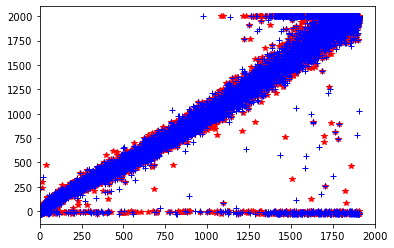

In [24]:
Y_poly_pred = PolyRegModel.predict(X_poly_test)
Y_poly_pred_f = PolyRegModel.predict(X_poly_test_f)
%matplotlib inline

plt.plot(Y_poly_pred,Y_test,'*r')
plt.plot(Y_poly_pred_f,Y_test_f,'+b')
plt.xlim(0, 2000) #Some weird outliers in the negative range, probably due to filling

 <span style="color:blue"> Now we will define our ANNreg model and run it for raw data first and then for the ffilled data.

In [25]:
# Define an ANN regressor
ANNreg = sklearn.neural_network.MLPRegressor(hidden_layer_sizes = (12,12), 
                                                activation = 'relu', 
                                                max_iter = 300, 
                                                verbose = True, 
                                                learning_rate_init = 0.1, 
                                                batch_size = X_train.shape[0])

In [26]:
# Check model fits with scaling
Xscaler = sklearn.preprocessing.StandardScaler() # Scaling object
Yscaler = sklearn.preprocessing.StandardScaler() # Scaling object
X_train_scaled = Xscaler.fit_transform(X_train) # fit the scales and apply
Y_train_scaled = Yscaler.fit_transform(Y_train[:,None]) # fit the scales and apply
X_train_f_scaled=Xscaler.fit_transform(X_train_f)
Y_train_f_scaled=Yscaler.fit_transform(Y_train_f[:,None])

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """
C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys


In [27]:
ANNreg.fit(X_train_scaled,Y_train_scaled)

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Iteration 1, loss = 0.48138413
Iteration 2, loss = 0.27558246
Iteration 3, loss = 0.20597495
Iteration 4, loss = 0.23848858
Iteration 5, loss = 0.13930889
Iteration 6, loss = 0.11514115
Iteration 7, loss = 0.13231320
Iteration 8, loss = 0.09774640
Iteration 9, loss = 0.08054076
Iteration 10, loss = 0.10285683
Iteration 11, loss = 0.11330329
Iteration 12, loss = 0.10066676
Iteration 13, loss = 0.08681449
Iteration 14, loss = 0.09077686
Iteration 15, loss = 0.09777449
Iteration 16, loss = 0.08874196
Iteration 17, loss = 0.07799370
Iteration 18, loss = 0.07737375
Iteration 19, loss = 0.08117041
Iteration 20, loss = 0.08107032
Iteration 21, loss = 0.07477010
Iteration 22, loss = 0.07143856
Iteration 23, loss = 0.07389450
Iteration 24, loss = 0.07272620
Iteration 25, loss = 0.06908995
Iteration 26, loss = 0.06646240
Iteration 27, loss = 0.06735751
Iteration 28, loss = 0.06321984
Iteration 29, loss = 0.06084949
Iteration 30, loss = 0.06253957
Iteration 31, loss = 0.06203369
Iteration 32, los

MLPRegressor(batch_size=69712, hidden_layer_sizes=(12, 12),
             learning_rate_init=0.1, max_iter=300, verbose=True)

In [28]:
Y_pred_ANN = Yscaler.inverse_transform(ANNreg.predict(Xscaler.transform(X_test)))

score_raw = ANNreg.score(Xscaler.transform(X_test),Yscaler.transform(Y_test.ravel().reshape(-1,1)))
score_raw 


0.8968542170073934

In [29]:
ANNreg.fit(X_train_f_scaled,Y_train_f_scaled)

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Iteration 1, loss = 0.61924107
Iteration 2, loss = 0.16170038
Iteration 3, loss = 0.12000395
Iteration 4, loss = 0.10542065
Iteration 5, loss = 0.10097025
Iteration 6, loss = 0.08955878
Iteration 7, loss = 0.07011846
Iteration 8, loss = 0.07168929
Iteration 9, loss = 0.06895372
Iteration 10, loss = 0.06608423
Iteration 11, loss = 0.06464532
Iteration 12, loss = 0.06172641
Iteration 13, loss = 0.05876920
Iteration 14, loss = 0.05836224
Iteration 15, loss = 0.06035715
Iteration 16, loss = 0.05888711
Iteration 17, loss = 0.05653899
Iteration 18, loss = 0.05573900
Iteration 19, loss = 0.05480179
Iteration 20, loss = 0.06458401
Iteration 21, loss = 0.05750374
Iteration 22, loss = 0.05701365
Iteration 23, loss = 0.06309735
Iteration 24, loss = 0.05846677
Iteration 25, loss = 0.05472710
Iteration 26, loss = 0.05702352
Iteration 27, loss = 0.05325490
Iteration 28, loss = 0.05301599
Iteration 29, loss = 0.05312229
Iteration 30, loss = 0.05282571
Iteration 31, loss = 0.05505540
Iteration 32, los

MLPRegressor(batch_size=69712, hidden_layer_sizes=(12, 12),
             learning_rate_init=0.1, max_iter=300, verbose=True)

In [30]:
Y_pred_ANN_f = Yscaler.inverse_transform(ANNreg.predict(Xscaler.transform(X_test_f)))

score_filled = ANNreg.score(Xscaler.transform(X_test_f),Yscaler.transform(Y_test_f.ravel().reshape(-1,1)))
score_filled 

0.8852301916122612

0.011624025395132187

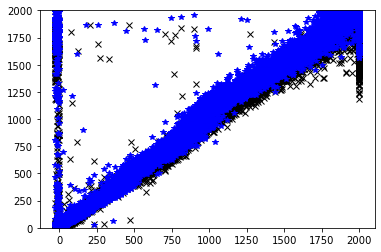

In [31]:
# Compare results
plt.plot(Y_test,Y_pred_ANN,'xk')
plt.plot(Y_test_f,Y_pred_ANN_f,'*b')


plt.ylim(0, 2000) #Some weird outliers in the negative range
score_raw - score_filled
# Raw results slightly better than filled

 <span style="color:blue"> Result: The prediction for the raw data is a bit more accurate than for the ffilled data.

### 2.2 Data effects - Wind vs. Wind + Power Gen.

 <span style="color:blue"> Now we will test how much influence the power variable has on the prediction for "itself".

In [32]:
# W = Wind
X_W = df_T01[['Amb_WindSpeed_Avg','Amb_WindSpeed_Std']] 
Y_W = df_T01.Grd_Prod_Pwr_Avg

# W = Wind, G = Grid power
X_WG = df_T01[['Amb_WindSpeed_Avg','Amb_WindSpeed_Std','Grd_Prod_Pwr_Avg']] 
Y_WG = Y_W

In [33]:
# Define train and test data
X_train_W, X_test_W, Y_train_W, Y_test_W = sklearn.model_selection.train_test_split(X, Y, 
                                                                        shuffle = True, test_size = 0.2)

#Define train and test data for ffilled data
X_train_WG, X_test_WG, Y_train_WG, Y_test_WG = sklearn.model_selection.train_test_split(X_f, Y_f, 
                                                                        shuffle = True, test_size = 0.2)

In [34]:
# Define polynomial degree and create new X matrixes for test and train data consisting of all polynomial combinations
PolynomialDegree = 6
PolyFeaturesObj = PolynomialFeatures(degree = PolynomialDegree)

X_poly_train_W = PolyFeaturesObj.fit_transform(X_train_W)
X_poly_test_W = PolyFeaturesObj.fit_transform(X_test_W)

X_poly_train_WG = PolyFeaturesObj.fit_transform(X_train_WG)
X_poly_test_WG = PolyFeaturesObj.fit_transform(X_test_WG)


#Select regression model and fit it to data
PolyRegModel = LinearRegression()
PolyRegModel.fit(X_poly_train_W,Y_train_W)

LinearRegression()

In [35]:
rsq_train_W = PolyRegModel.score(X_poly_train_W,Y_train_W)
rsq_train_W

0.8978349098060103

In [36]:
rsq_train_WG = PolyRegModel.score(X_poly_train_WG,Y_train_WG)
rsq_train_WG

-1.9184045327620822

In [37]:
rsq_test = PolyRegModel.score(X_poly_test_W,Y_test_W)
rsq_test

-68144.12121615383

In [38]:
rsq_test_f = PolyRegModel.score(X_poly_test_WG,Y_test_WG)
rsq_test_f

-69584.18090335309

(0.0, 2000.0)

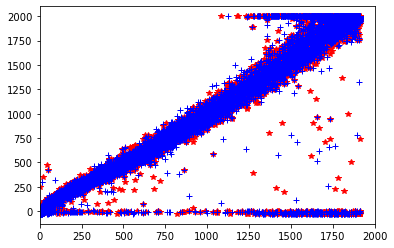

In [39]:
Y_poly_pred_W = PolyRegModel.predict(X_poly_test_W)
Y_poly_pred_WG = PolyRegModel.predict(X_poly_test_WG)
%matplotlib inline

plt.plot(Y_poly_pred_W,Y_test_W,'*r')
plt.plot(Y_poly_pred_WG,Y_test_WG,'+b')

plt.xlim(0, 2000)
#Something weird happens for some values for only wind

 <span style="color:blue"> The polynomial model gives rather inconclusive results.

In [40]:
# Define an ANN regressor
ANNreg = sklearn.neural_network.MLPRegressor(hidden_layer_sizes = (6,6), 
                                                activation = 'relu', 
                                                max_iter = 300, 
                                                verbose = True, 
                                                learning_rate_init = 0.1, 
                                                batch_size = X_train_W.shape[0])

In [41]:
# Check model fits with scaling
Xscaler = sklearn.preprocessing.StandardScaler() # Scaling object
Yscaler = sklearn.preprocessing.StandardScaler() # Scaling object
X_train_scaled_W = Xscaler.fit_transform(X_train_W) # fit the scales and apply
Y_train_scaled_W = Yscaler.fit_transform(Y_train_W[:,None]) # fit the scales and apply
X_train_scaled_WG=Xscaler.fit_transform(X_train_WG)
Y_train_scaled_WG=Yscaler.fit_transform(Y_train_WG[:,None])

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """
C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  import sys


In [42]:
ANNreg.fit(X_train_scaled_W,Y_train_scaled_W)

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Iteration 1, loss = 1.21319474
Iteration 2, loss = 0.22664196
Iteration 3, loss = 0.28627282
Iteration 4, loss = 0.32230688
Iteration 5, loss = 0.23390262
Iteration 6, loss = 0.15522780
Iteration 7, loss = 0.14142474
Iteration 8, loss = 0.15523370
Iteration 9, loss = 0.16333212
Iteration 10, loss = 0.15150392
Iteration 11, loss = 0.13269799
Iteration 12, loss = 0.12128438
Iteration 13, loss = 0.12008827
Iteration 14, loss = 0.12399949
Iteration 15, loss = 0.12682951
Iteration 16, loss = 0.12549569
Iteration 17, loss = 0.12154147
Iteration 18, loss = 0.11570105
Iteration 19, loss = 0.10988796
Iteration 20, loss = 0.10613831
Iteration 21, loss = 0.10537273
Iteration 22, loss = 0.10670683
Iteration 23, loss = 0.10790808
Iteration 24, loss = 0.10704637
Iteration 25, loss = 0.10391526
Iteration 26, loss = 0.09993425
Iteration 27, loss = 0.09684261
Iteration 28, loss = 0.09546229
Iteration 29, loss = 0.09540372
Iteration 30, loss = 0.09560158
Iteration 31, loss = 0.09511040
Iteration 32, los

MLPRegressor(batch_size=69712, hidden_layer_sizes=(6, 6),
             learning_rate_init=0.1, max_iter=300, verbose=True)

In [43]:
score_W = ANNreg.score(Xscaler.transform(X_test_W),Yscaler.transform(Y_test_W.ravel().reshape(-1,1)))

Y_pred_ANN_W = Yscaler.inverse_transform(ANNreg.predict(Xscaler.transform(X_test_W)))

score_W

0.8742381993848961

In [44]:
ANNreg.fit(X_train_scaled_WG,Y_train_scaled_WG)

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Iteration 1, loss = 0.82694398
Iteration 2, loss = 0.24293603
Iteration 3, loss = 0.25139367
Iteration 4, loss = 0.16932461
Iteration 5, loss = 0.12040546
Iteration 6, loss = 0.10102108
Iteration 7, loss = 0.10046830
Iteration 8, loss = 0.09347038
Iteration 9, loss = 0.07824051
Iteration 10, loss = 0.08647733
Iteration 11, loss = 0.07406829
Iteration 12, loss = 0.07298900
Iteration 13, loss = 0.07471326
Iteration 14, loss = 0.06845975
Iteration 15, loss = 0.07275431
Iteration 16, loss = 0.06923642
Iteration 17, loss = 0.07104290
Iteration 18, loss = 0.06582749
Iteration 19, loss = 0.06767303
Iteration 20, loss = 0.06425025
Iteration 21, loss = 0.06612290
Iteration 22, loss = 0.06405923
Iteration 23, loss = 0.06354570
Iteration 24, loss = 0.06293684
Iteration 25, loss = 0.06241267
Iteration 26, loss = 0.06344034
Iteration 27, loss = 0.06138257
Iteration 28, loss = 0.06228807
Iteration 29, loss = 0.06194481
Iteration 30, loss = 0.06161094
Iteration 31, loss = 0.06295391
Iteration 32, los

MLPRegressor(batch_size=69712, hidden_layer_sizes=(6, 6),
             learning_rate_init=0.1, max_iter=300, verbose=True)

In [45]:
score_WG = ANNreg.score(Xscaler.transform(X_test_WG),Yscaler.transform(Y_test_WG.ravel().reshape(-1,1)))

Y_pred_ANN_WG = Yscaler.inverse_transform(ANNreg.predict(Xscaler.transform(X_test_WG)))

score_WG

0.8944676237653457

0.020229424380449612

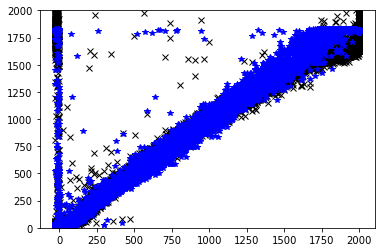

In [46]:
plt.plot(Y_test_W,Y_pred_ANN_W,'xk')
plt.plot(Y_test_WG,Y_pred_ANN_WG,'*b')
plt.ylim(0, 2000)

score_WG - score_W
# Adding previous power generation slightly improves results

 <span style="color:blue"> Result: The prediction for power output based on either only wind or wind+ power data does not differ significantly.
    

### 2.3 Neuron and layer effects

 <span style="color:blue"> Now, we will see how different amounts of neurons and layers affect the score value. We will test for 1-3 layers with either 6,12, or 24 neurons each. The possible combinations are therefore:
    [[6], [12], [24], [6, 6], [12, 12], [24, 24], [6, 6, 6], [12, 12, 12], [24, 24, 24]]
    
 <span style="color:blue">  Note: Other combinations like [24,12,6] might make more sense but are not tested here for now.
    

In [47]:
X = df_T01[['Amb_WindSpeed_Avg','Amb_WindSpeed_Std','Grd_Prod_Pwr_Avg']] 
Y = df_T01[['Grd_Prod_Pwr_Avg']]

In [48]:
# Define train and test data
X_train_W, X_test_W, Y_train_W, Y_test_W = sklearn.model_selection.train_test_split(X, Y, 
                                                                        shuffle = True, test_size = 0.2)

#Define train and test data for ffilled data
X_train_WG, X_test_WG, Y_train_WG, Y_test_WG = sklearn.model_selection.train_test_split(X_f, Y_f, 
                                                                        shuffle = True, test_size = 0.2)

In [49]:
# Check model fits with scaling
Xscaler = sklearn.preprocessing.StandardScaler() # Scaling object
Yscaler = sklearn.preprocessing.StandardScaler() # Scaling object
X_train_scaled = Xscaler.fit_transform(X_train) # fit the scales and apply
Y_train_scaled = Yscaler.fit_transform(Y_train[:,None]) # fit the scales and apply


C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """


In [50]:
Neurons = [6,12,24]
Hidden_Layers = [1,2,3]
ID = []

for i in Hidden_Layers:
    for ii in Neurons:
        layer_and_size = [ii]*i
        
   
        ID.append(layer_and_size)
    
print(ID)
        

[[6], [12], [24], [6, 6], [12, 12], [24, 24], [6, 6, 6], [12, 12, 12], [24, 24, 24]]


In [51]:
# Define an ANN regressor
Neurons = [6,12,24]
Hidden_Layers = [1,2,3]
scores = []
Y_pred = []
ID = []

for i in Hidden_Layers:
    for ii in Neurons:
        layer_and_size = [ii]*i
        
        ANNreg = sklearn.neural_network.MLPRegressor(hidden_layer_sizes = layer_and_size, 
                                                activation = 'relu', 
                                                max_iter = 300, 
                                                verbose = True, 
                                                learning_rate_init = 0.1, 
                                                batch_size = X_train.shape[0])
        ANNreg.fit(X_train_scaled_W,Y_train_scaled_W)
        
        scores.append(ANNreg.score(Xscaler.transform(X_test),Yscaler.transform(Y_test.ravel().reshape(-1,1))))

        Y_pred.append(Yscaler.inverse_transform(ANNreg.predict(Xscaler.transform(X_test))))
        ID.append(layer_and_size)

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Iteration 1, loss = 0.35304323
Iteration 2, loss = 0.16789620
Iteration 3, loss = 0.25701513
Iteration 4, loss = 0.22125625
Iteration 5, loss = 0.16264700
Iteration 6, loss = 0.15408538
Iteration 7, loss = 0.17351729
Iteration 8, loss = 0.17931441
Iteration 9, loss = 0.15943217
Iteration 10, loss = 0.12597480
Iteration 11, loss = 0.09848661
Iteration 12, loss = 0.09397221
Iteration 13, loss = 0.11020218
Iteration 14, loss = 0.11575712
Iteration 15, loss = 0.10232329
Iteration 16, loss = 0.08538662
Iteration 17, loss = 0.07955850
Iteration 18, loss = 0.08526398
Iteration 19, loss = 0.09267427
Iteration 20, loss = 0.09331105
Iteration 21, loss = 0.08652153
Iteration 22, loss = 0.07820682
Iteration 23, loss = 0.07505945
Iteration 24, loss = 0.07855511
Iteration 25, loss = 0.08346930
Iteration 26, loss = 0.08368807
Iteration 27, loss = 0.07916326
Iteration 28, loss = 0.07499379
Iteration 29, loss = 0.07502246
Iteration 30, loss = 0.07805133
Iteration 31, loss = 0.07997863
Iteration 32, los

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Iteration 1, loss = 1.28732317
Iteration 2, loss = 0.34429828
Iteration 3, loss = 0.19845910
Iteration 4, loss = 0.29951815
Iteration 5, loss = 0.26736984
Iteration 6, loss = 0.19244763
Iteration 7, loss = 0.13162821
Iteration 8, loss = 0.11197347
Iteration 9, loss = 0.12728012
Iteration 10, loss = 0.13953615
Iteration 11, loss = 0.14121720
Iteration 12, loss = 0.12572163
Iteration 13, loss = 0.10023351
Iteration 14, loss = 0.08243416
Iteration 15, loss = 0.08510206
Iteration 16, loss = 0.10238233
Iteration 17, loss = 0.11181179
Iteration 18, loss = 0.10212419
Iteration 19, loss = 0.08480132
Iteration 20, loss = 0.07596047
Iteration 21, loss = 0.07890686
Iteration 22, loss = 0.08383255
Iteration 23, loss = 0.08226329
Iteration 24, loss = 0.07675756
Iteration 25, loss = 0.07485364
Iteration 26, loss = 0.07781294
Iteration 27, loss = 0.07883608
Iteration 28, loss = 0.07335882
Iteration 29, loss = 0.06606328
Iteration 30, loss = 0.06405338
Iteration 31, loss = 0.06702933
Iteration 32, los

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Iteration 2, loss = 0.19389055
Iteration 3, loss = 0.22100314
Iteration 4, loss = 0.12266406
Iteration 5, loss = 0.13663331
Iteration 6, loss = 0.15778978
Iteration 7, loss = 0.13624711
Iteration 8, loss = 0.10130577
Iteration 9, loss = 0.08806563
Iteration 10, loss = 0.10301504
Iteration 11, loss = 0.10040234
Iteration 12, loss = 0.08032592
Iteration 13, loss = 0.08660555
Iteration 14, loss = 0.09055294
Iteration 15, loss = 0.08008321
Iteration 16, loss = 0.07298331
Iteration 17, loss = 0.08101374
Iteration 18, loss = 0.08093802
Iteration 19, loss = 0.07291691
Iteration 20, loss = 0.07152286
Iteration 21, loss = 0.07226233
Iteration 22, loss = 0.06980720
Iteration 23, loss = 0.06349444
Iteration 24, loss = 0.06568448
Iteration 25, loss = 0.06750881
Iteration 26, loss = 0.06347502
Iteration 27, loss = 0.06140761
Iteration 28, loss = 0.06121983
Iteration 29, loss = 0.06078947
Iteration 30, loss = 0.05892080
Iteration 31, loss = 0.06031642
Iteration 32, loss = 0.06058269
Iteration 33, lo

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



Iteration 3, loss = 0.14959428
Iteration 4, loss = 0.10872596
Iteration 5, loss = 0.08497944
Iteration 6, loss = 0.10309840
Iteration 7, loss = 0.10289128
Iteration 8, loss = 0.08279681
Iteration 9, loss = 0.07467353
Iteration 10, loss = 0.07130920
Iteration 11, loss = 0.07879661
Iteration 12, loss = 0.08122907
Iteration 13, loss = 0.06892857
Iteration 14, loss = 0.06257042
Iteration 15, loss = 0.06355936
Iteration 16, loss = 0.06301906
Iteration 17, loss = 0.06832865
Iteration 18, loss = 0.06383618
Iteration 19, loss = 0.05744713
Iteration 20, loss = 0.05849722
Iteration 21, loss = 0.05837401
Iteration 22, loss = 0.06021275
Iteration 23, loss = 0.06056930
Iteration 24, loss = 0.05597665
Iteration 25, loss = 0.05498401
Iteration 26, loss = 0.05694078
Iteration 27, loss = 0.05647202
Iteration 28, loss = 0.05688817
Iteration 29, loss = 0.05490396
Iteration 30, loss = 0.05319413
Iteration 31, loss = 0.05491981
Iteration 32, loss = 0.05500720
Iteration 33, loss = 0.05406131
Iteration 34, 

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Iteration 1, loss = 0.91010347
Iteration 2, loss = 0.53443959
Iteration 3, loss = 0.29148128
Iteration 4, loss = 0.23834201
Iteration 5, loss = 0.20472184
Iteration 6, loss = 0.17493418
Iteration 7, loss = 0.11543811
Iteration 8, loss = 0.09506943
Iteration 9, loss = 0.09960331
Iteration 10, loss = 0.13236220
Iteration 11, loss = 0.12536595
Iteration 12, loss = 0.09313115
Iteration 13, loss = 0.09143251
Iteration 14, loss = 0.09293911
Iteration 15, loss = 0.09763165
Iteration 16, loss = 0.09169816
Iteration 17, loss = 0.08830129
Iteration 18, loss = 0.08436522
Iteration 19, loss = 0.07855077
Iteration 20, loss = 0.08283635
Iteration 21, loss = 0.08437558
Iteration 22, loss = 0.08852385
Iteration 23, loss = 0.08626299
Iteration 24, loss = 0.08176179
Iteration 25, loss = 0.08098027
Iteration 26, loss = 0.07982742
Iteration 27, loss = 0.08282667
Iteration 28, loss = 0.08173324
Iteration 29, loss = 0.08071382
Iteration 30, loss = 0.07806738
Iteration 31, loss = 0.07634138
Iteration 32, los

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Iteration 1, loss = 0.62967276
Iteration 2, loss = 0.30941244
Iteration 3, loss = 0.27368538
Iteration 4, loss = 0.42643248
Iteration 5, loss = 0.12316706
Iteration 6, loss = 0.19082749
Iteration 7, loss = 0.16506426
Iteration 8, loss = 0.08825360
Iteration 9, loss = 0.11440123
Iteration 10, loss = 0.12698204
Iteration 11, loss = 0.09110207
Iteration 12, loss = 0.07957224
Iteration 13, loss = 0.10958842
Iteration 14, loss = 0.10463564
Iteration 15, loss = 0.08373440
Iteration 16, loss = 0.07446847
Iteration 17, loss = 0.07437183
Iteration 18, loss = 0.07271746
Iteration 19, loss = 0.06529989
Iteration 20, loss = 0.06540055
Iteration 21, loss = 0.07077220
Iteration 22, loss = 0.06342623
Iteration 23, loss = 0.06363220
Iteration 24, loss = 0.06661576
Iteration 25, loss = 0.06066488
Iteration 26, loss = 0.06084451
Iteration 27, loss = 0.06214764
Iteration 28, loss = 0.05691628
Iteration 29, loss = 0.05843689
Iteration 30, loss = 0.06023608
Iteration 31, loss = 0.05671411
Iteration 32, los

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)



Iteration 3, loss = 0.41831605
Iteration 4, loss = 0.26529205
Iteration 5, loss = 0.18538665
Iteration 6, loss = 0.20809151
Iteration 7, loss = 0.21180650
Iteration 8, loss = 0.17619767
Iteration 9, loss = 0.13088305
Iteration 10, loss = 0.13087048
Iteration 11, loss = 0.16534321
Iteration 12, loss = 0.14236910
Iteration 13, loss = 0.10990055
Iteration 14, loss = 0.11214443
Iteration 15, loss = 0.12461345
Iteration 16, loss = 0.12412877
Iteration 17, loss = 0.11085667
Iteration 18, loss = 0.09875354
Iteration 19, loss = 0.09888781
Iteration 20, loss = 0.10351672
Iteration 21, loss = 0.10211420
Iteration 22, loss = 0.09581266
Iteration 23, loss = 0.09085481
Iteration 24, loss = 0.09125970
Iteration 25, loss = 0.09186178
Iteration 26, loss = 0.08915091
Iteration 27, loss = 0.08557262
Iteration 28, loss = 0.08352515
Iteration 29, loss = 0.08070006
Iteration 30, loss = 0.07676683
Iteration 31, loss = 0.07621524
Iteration 32, loss = 0.07749774
Iteration 33, loss = 0.07510316
Iteration 34, 

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Iteration 2, loss = 4.70242766
Iteration 3, loss = 0.25708966
Iteration 4, loss = 0.66048363
Iteration 5, loss = 0.58202046
Iteration 6, loss = 0.47103121
Iteration 7, loss = 0.40841927
Iteration 8, loss = 0.35311383
Iteration 9, loss = 0.28232566
Iteration 10, loss = 0.22608060
Iteration 11, loss = 0.17439914
Iteration 12, loss = 0.12808985
Iteration 13, loss = 0.11863602
Iteration 14, loss = 0.12255994
Iteration 15, loss = 0.13922585
Iteration 16, loss = 0.14461489
Iteration 17, loss = 0.12401683
Iteration 18, loss = 0.11166417
Iteration 19, loss = 0.09663642
Iteration 20, loss = 0.10247402
Iteration 21, loss = 0.10324208
Iteration 22, loss = 0.11150739
Iteration 23, loss = 0.11176933
Iteration 24, loss = 0.11060050
Iteration 25, loss = 0.10752480
Iteration 26, loss = 0.09923221
Iteration 27, loss = 0.09411332
Iteration 28, loss = 0.08793269
Iteration 29, loss = 0.08291399
Iteration 30, loss = 0.08330116
Iteration 31, loss = 0.08588161
Iteration 32, loss = 0.08786181
Iteration 33, lo

C:\ProgramData\Anaconda3\envs\DataScience2020\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Iteration 1, loss = 0.47800377
Iteration 2, loss = 1.42019628
Iteration 3, loss = 5.96855618
Iteration 4, loss = 1.50613606
Iteration 5, loss = 0.54119306
Iteration 6, loss = 0.43098214
Iteration 7, loss = 0.47485752
Iteration 8, loss = 0.41348941
Iteration 9, loss = 0.32835550
Iteration 10, loss = 0.23620837
Iteration 11, loss = 0.19877548
Iteration 12, loss = 0.16580542
Iteration 13, loss = 0.16775601
Iteration 14, loss = 0.13378320
Iteration 15, loss = 0.12575797
Iteration 16, loss = 0.10888558
Iteration 17, loss = 0.09055771
Iteration 18, loss = 0.09801108
Iteration 19, loss = 0.07536467
Iteration 20, loss = 0.08715361
Iteration 21, loss = 0.07108963
Iteration 22, loss = 0.08096704
Iteration 23, loss = 0.06814413
Iteration 24, loss = 0.07623173
Iteration 25, loss = 0.06689105
Iteration 26, loss = 0.07020148
Iteration 27, loss = 0.06609941
Iteration 28, loss = 0.06497400
Iteration 29, loss = 0.06770671
Iteration 30, loss = 0.06458639
Iteration 31, loss = 0.06702273
Iteration 32, los

In [52]:
scores

[0.889042195900596,
 0.8948886849824036,
 0.8976926022429307,
 0.8960318841412989,
 0.8958231031290139,
 0.8968513924339798,
 0.8966150034206817,
 0.897234503658274,
 0.8969734520240678]

<span style="color:blue">  The model with only one layer and 6 neurons clearly loses to larger models. None of the models seem to score very high.

In [53]:
Y_pred

[array([1208.43215141,   43.39952371, 1613.63941852, ...,  530.8745498 ,
         160.46424287, 1743.40563863]),
 array([1216.59662315,   27.94695269, 1695.02561454, ...,  531.61620614,
         172.64134628, 1692.68986438]),
 array([1210.4878267 ,   15.28502596, 1656.10431675, ...,  494.91742714,
         194.67896492, 1665.5648924 ]),
 array([1215.54831093,   37.39582574, 1660.07562186, ...,  520.83744254,
         162.16186052, 1648.46948277]),
 array([1218.5181551 ,   28.84800001, 1678.59298453, ...,  479.86681183,
         168.85520775, 1659.32643386]),
 array([1224.69321819,   11.19912092, 1630.35858903, ...,  490.9766247 ,
         213.3108735 , 1629.82654383]),
 array([1249.05065122,   11.4287897 , 1634.60435067, ...,  498.44018577,
         232.28460037, 1673.30603866]),
 array([1214.97590746,   -3.90533106, 1625.4352846 , ...,  475.35482453,
         237.81878446, 1616.65701352]),
 array([1232.86410633,    1.70735984, 1643.80475562, ...,  484.7656511 ,
         178.13326918, 

In [54]:
df = pd.DataFrame(Y_pred, index = range(len(Y_pred)))
df = df.transpose()
df[9] = Y_test.values
df.columns = ([6,12,24,6_6,12_12,24_24,6_6_6,12_12_12,24_24_24,'Original'])

df

,6,12,24,66,1212,2424,666,121212,242424,Original
0,1208.432151,1216.596623,1210.487827,1215.548311,1218.518155,1224.693218,1249.050651,1214.975907,1232.864106,1285.0
1,43.399524,27.946953,15.285026,37.395826,28.848000,11.199121,11.428790,-3.905331,1.707360,-12.1
2,1613.639419,1695.025615,1656.104317,1660.075622,1678.592985,1630.358589,1634.604351,1625.435285,1643.804756,1829.1
3,1032.701403,1043.079546,1020.020958,1034.944373,1053.969282,1048.584790,1054.272191,1035.997719,1039.566657,1067.0
4,124.929184,100.099107,120.550402,110.893747,139.614285,124.651569,94.108196,137.470005,142.493635,59.5
...,...,...,...,...,...,...,...,...,...,...
17423,97.934193,63.795481,91.293090,87.579959,121.844804,96.440751,33.352378,93.995052,110.997267,119.9
17424,62.771763,42.351378,39.132075,49.491915,37.432858,25.427946,15.830050,-3.905331,17.108368,9.7
17425,530.874550,531.616206,494.917427,520.837443,479.866812,490.976625,498.440186,475.354825,484.765651,553.3
17426,160.464243,172.641346,194.678965,162.161861,168.855208,213.310873,232.284600,237.818784,178.133269,230.7


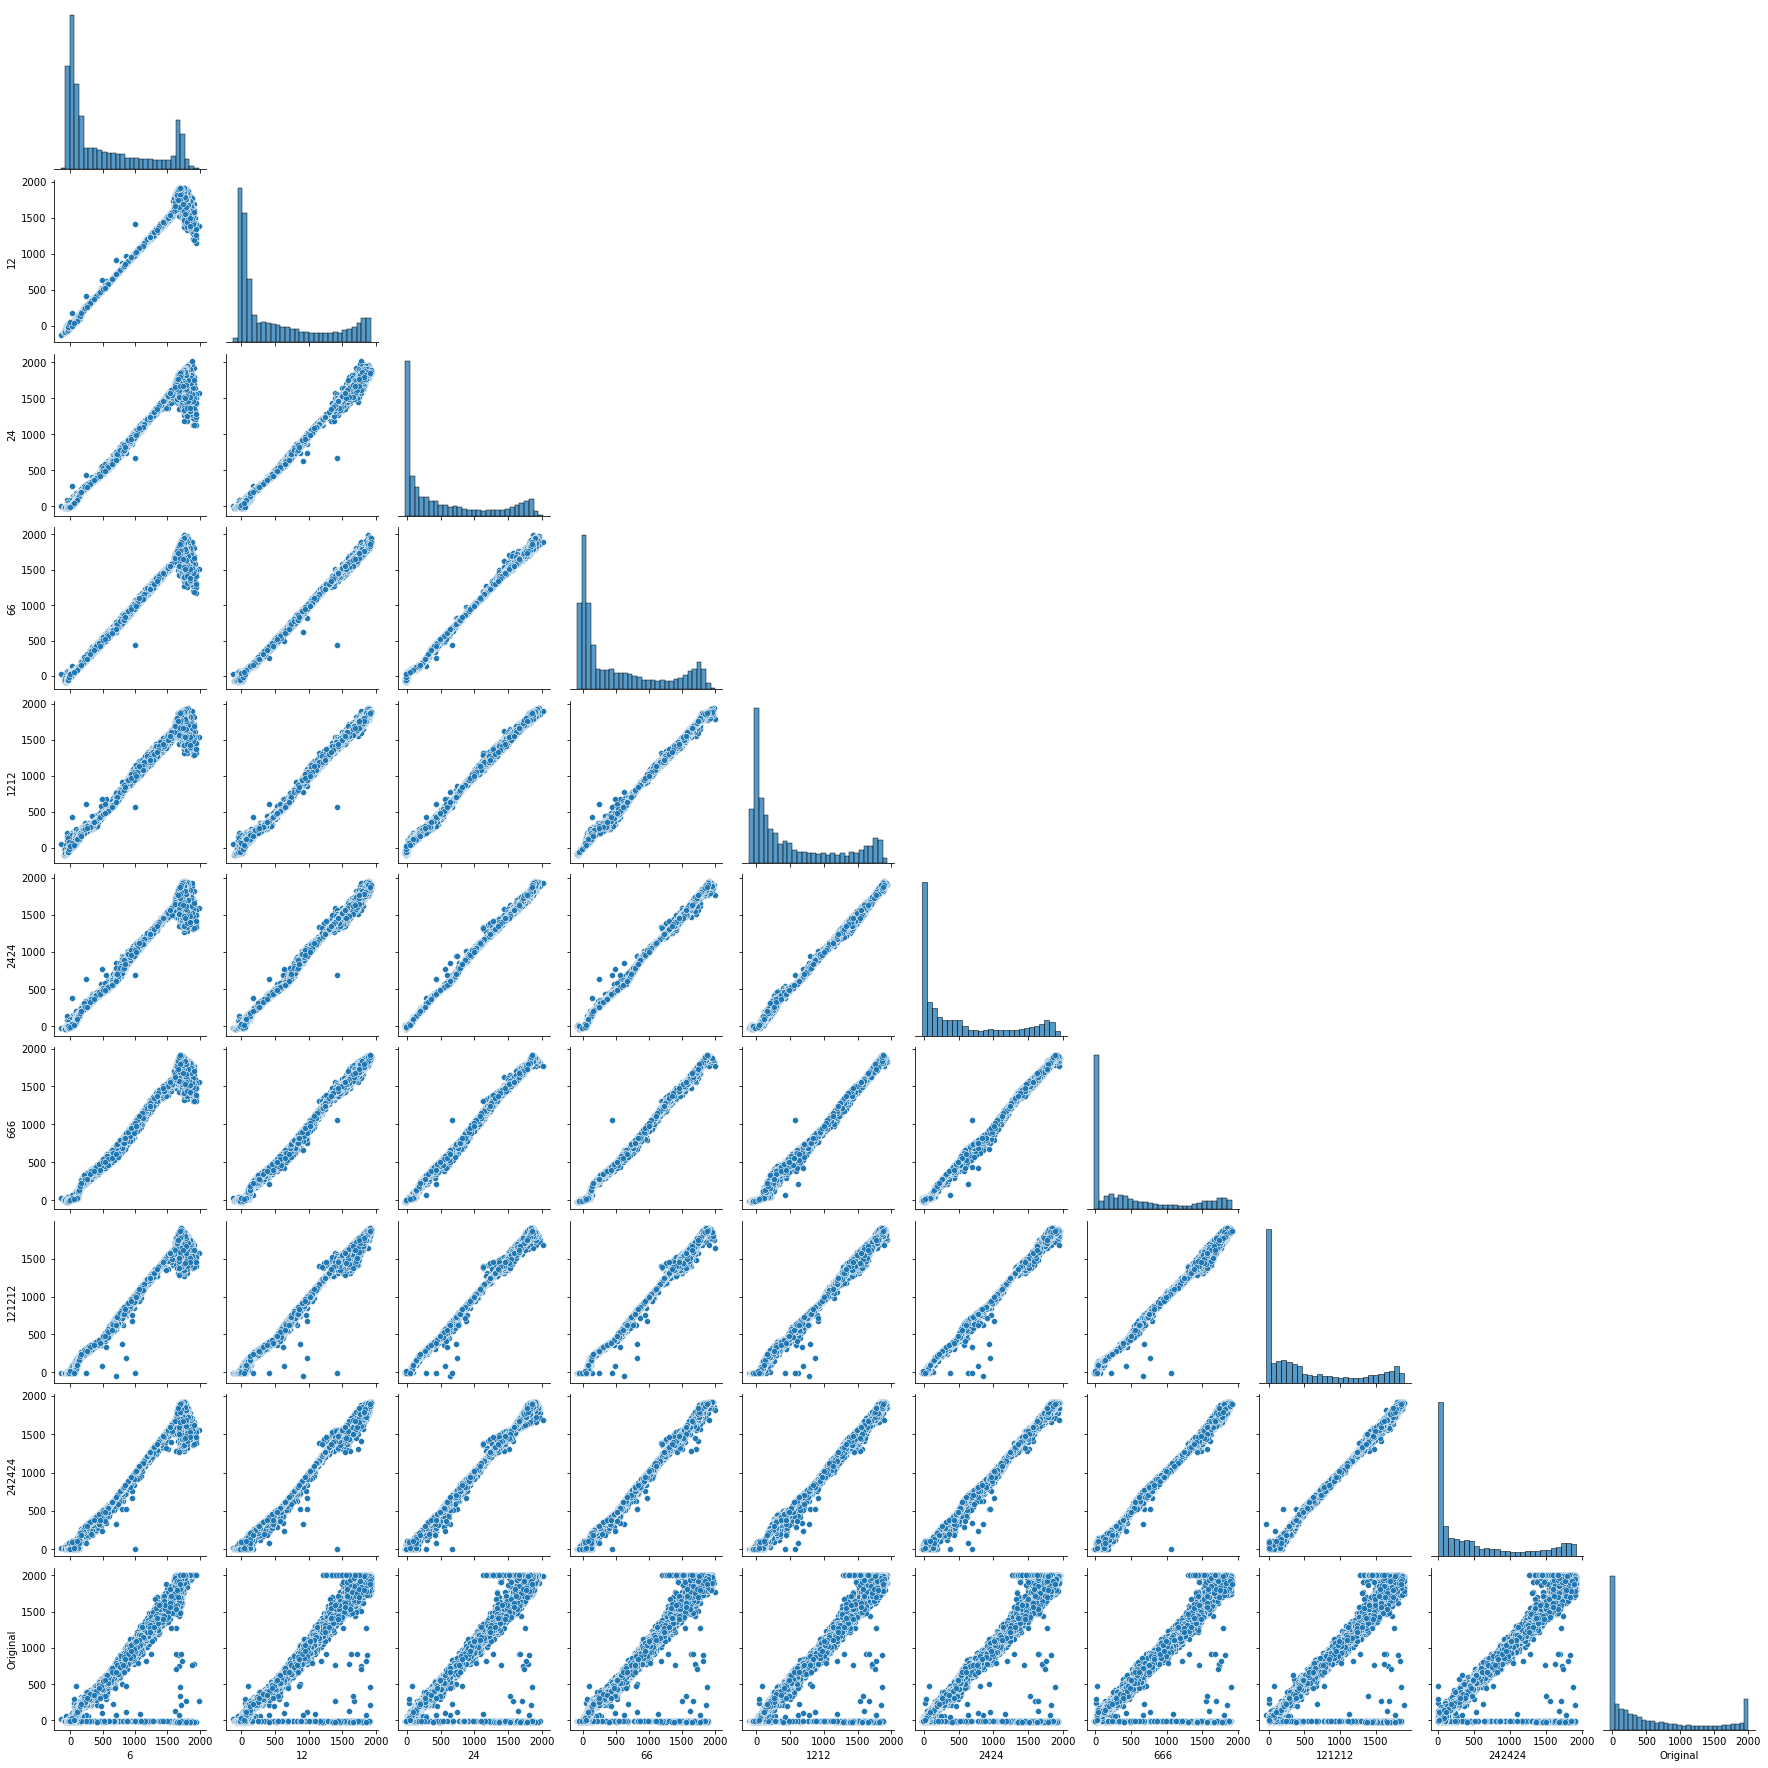

In [55]:
sns.pairplot(df, corner = True)

In [56]:
df.corr()

,6,12,24,66,1212,2424,666,121212,242424,Original
6,1.000000,0.995460,0.995403,0.996096,0.995639,0.994616,0.994765,0.994018,0.993817,0.943047
12,0.995460,1.000000,0.998700,0.999164,0.998467,0.998410,0.998205,0.997355,0.997083,0.945995
24,0.995403,0.998700,1.000000,0.999271,0.999004,0.999500,0.999073,0.998975,0.998662,0.947518
66,0.996096,0.999164,0.999271,1.000000,0.999074,0.998894,0.998570,0.998108,0.997845,0.946658
1212,0.995639,0.998467,0.999004,0.999074,1.000000,0.999012,0.998025,0.998053,0.997969,0.946527
2424,0.994616,0.998410,0.999500,0.998894,0.999012,1.000000,0.998911,0.998976,0.998543,0.947090
666,0.994765,0.998205,0.999073,0.998570,0.998025,0.998911,1.000000,0.998675,0.998430,0.946924
121212,0.994018,0.997355,0.998975,0.998108,0.998053,0.998976,0.998675,1.000000,0.998748,0.947429
242424,0.993817,0.997083,0.998662,0.997845,0.997969,0.998543,0.998430,0.998748,1.000000,0.947104
Original,0.943047,0.945995,0.947518,0.946658,0.946527,0.947090,0.946924,0.947429,0.947104,1.000000


<span style="color:blue">  The best MLPRegressor model seems to be of a [24,24] structure.

#  3. Prediction model with ANNreg MLPRegressor

<span style="color:blue">  Based on the previous tests, we will create a model for the windfarm power generation using:
    
    1. Ffilled data as input 
    
    2. Using both Wind and Power generation from previous timesteps as input
    
    3. Use a 2-layer approach with "rather more than fewer" neurons

 <span style="color:blue"> We will now also use time shifting meaning we will predict future values based on past valious.   

In [57]:
### define a function that will prepare the shifting input sequences for the network
def forecast_sequences_input(input_data,n_lag):
    """
    A function that will split the input time series to sequences for nowcast/forecast problems
    Arguments:
        input_data: Time series of input observations as a list, NumPy array or pandas series
        n_lag: number of previous time steps to use for training, a.k.a. time-lag        
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = input_data.shape[1] 
    df = pd.DataFrame(input_data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_lag, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg


### define a function that will prepare the shifting output sequences of the network
def forecast_sequences_output(output_data,n_out):
    """
    A function that will split the output time series to sequences for nowcast/forecast problems
    Arguments:
        output_data: Time series of input observations as a list, NumPy array or pandas series
        n_out: forecast horizon (for multi-output forecast)
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = output_data.shape[1] 
    df = pd.DataFrame(output_data)
    cols, names = list(), list()
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names    
    return agg
X = dataset[['Amb_WindSpeed_Avg','Amb_WindSpeed_Std']] #'Amb_WindDir_Relative_Avg','Grd_Prod_Pwr_Avg'
Y = dataset.Grd_Prod_Pwr_Avg

In [58]:
n_lag = 6 # number of previous time steps to use for training, a.k.a. time-lag
n_out = 6  # forecast horizon [s] 

 <span style="color:blue"> We will only use train and validation data for our model

In [205]:
### Split data into train & test 
train_int = np.int(0.8*len(dataset)) # 60% of the data length for training
validation_int = np.int(1*len(dataset)) # 20% more for validation

# training input vector
X_train = dataset[['Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std','Amb_WindSpeed_Min','Amb_WindSpeed_Max','Grd_Prod_Pwr_Avg','Status_Flag']][:train_int]
X_train = forecast_sequences_input(X_train,n_lag)

# training output vector
Y_train = dataset[['Grd_Prod_Pwr_Avg']][:train_int]
Y_train = forecast_sequences_output(Y_train, n_out)

# validation input vector
X_validation = dataset[['Amb_WindSpeed_Avg', 'Amb_WindSpeed_Std','Amb_WindSpeed_Min','Amb_WindSpeed_Max','Grd_Prod_Pwr_Avg','Status_Flag']][train_int:validation_int]
X_validation = forecast_sequences_input(X_validation,n_lag)

# validation output vector
Y_validation = dataset[['Grd_Prod_Pwr_Avg']][train_int:validation_int]
Y_validation = forecast_sequences_output(Y_validation, n_out)



In [206]:
#Check data
X_train

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),...,var3(t-2),var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1)
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-02 10:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-02 10:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.7,0.6,0.7,6.6,-5.7,2.0
2016-01-02 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.7,6.6,-5.7,2.0,2.9,0.6,0.7,4.8,-5.2,2.0
2016-01-02 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.7,4.8,-5.2,2.0,3.4,0.9,0.5,9.5,1.9,1.0
2016-01-02 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.5,9.5,1.9,1.0,3.8,1.2,0.6,8.8,44.1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-10 21:40:00,8.3,1.8,2.0,24.4,941.3,0.0,8.0,1.7,1.6,18.9,...,1.7,30.9,1552.1,0.0,9.1,1.7,1.3,24.4,1322.3,0.0
2017-05-10 21:50:00,8.0,1.7,1.6,18.9,885.7,0.0,10.1,2.1,1.9,26.0,...,1.3,24.4,1322.3,0.0,9.6,1.9,2.4,17.3,1427.2,0.0
2017-05-10 22:30:00,10.1,2.1,1.9,26.0,1612.8,0.0,10.1,1.8,1.9,21.8,...,2.4,17.3,1427.2,0.0,9.1,1.8,2.0,17.6,1337.5,0.0


In [207]:
# Check model fits with scaling
Xscaler = sklearn.preprocessing.StandardScaler() # Scaling object
Yscaler = sklearn.preprocessing.StandardScaler() # Scaling object
X_train_scaled = Xscaler.fit_transform(X_train) # fit the scales and apply
Y_train_scaled = Yscaler.fit_transform(Y_train) # fit the scales and apply
X_validation_scaled = Xscaler.fit_transform(X_validation) # fit the scales and apply
Y_validation_scaled = Yscaler.fit_transform(Y_validation) # fit the scales and apply

(347316, 36)
[[        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ... -0.81759435 -0.80256731
   1.46515487]
 [        nan         nan         nan ... -1.06306768 -0.80181537
   1.46515487]
 ...
 [ 1.12063948  1.19708969  0.21847338 ...  0.68252043  1.21744448
  -0.81390275]
 [ 1.12063948  0.80466332  0.21847338 ...  1.88261225  1.57566873
  -0.81390275]
 [ 1.03835385  0.93547211  0.04816044 ...  1.15982968  1.1369869
  -0.81390275]]


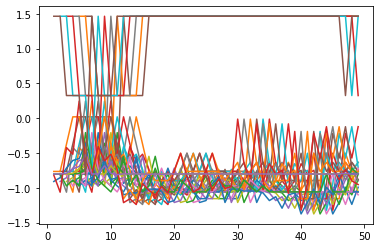

In [208]:
#Check what X_train_scaled looks like
print(X_train_scaled.shape)
print(X_train_scaled)
plt.plot(X_train_scaled[:50])

 <span style="color:blue"> Using masking was more complicated than expected, so we fill the data with mean values instead.

In [209]:
# Fill all data with mean values

col_mean = np.nanmean(X_train_scaled, axis=0)
inds = np.where(np.isnan(X_train_scaled))
X_train_scaled[inds] = np.take(col_mean, inds[1])

col_mean = np.nanmean(X_validation_scaled, axis=0)
inds = np.where(np.isnan(X_validation_scaled))
X_validation_scaled[inds] = np.take(col_mean, inds[1])


col_mean = np.nanmean(Y_train_scaled, axis=0)
inds = np.where(np.isnan(Y_train_scaled))
Y_train_scaled[inds] = np.take(col_mean, inds[1])

col_mean = np.nanmean(Y_validation_scaled, axis=0)
inds = np.where(np.isnan(Y_validation_scaled))
Y_validation_scaled[inds] = np.take(col_mean, inds[1])

[[-8.02570246e-01 -8.01820206e-01 -7.91144568e-01 -7.27682802e-01
  -6.92493702e-01 -5.26016207e-01]
 [-8.01818306e-01 -7.91142666e-01 -7.27680916e-01 -6.92492076e-01
  -5.26014608e-01 -8.00924569e-01]
 [-7.91140761e-01 -7.27678982e-01 -6.92490171e-01 -5.26012869e-01
  -8.00923175e-01 -8.01826894e-01]
 ...
 [ 1.57566489e+00  1.13698033e+00  1.12494641e+00 -3.33879165e-16
  -2.10802747e-16  1.76760576e-17]
 [ 1.13698322e+00  1.12494930e+00  2.01636249e-16 -3.33879165e-16
  -2.10802747e-16  1.76760576e-17]
 [ 1.12495219e+00  5.76101909e-17  2.01636249e-16 -3.33879165e-16
  -2.10802747e-16  1.76760576e-17]]


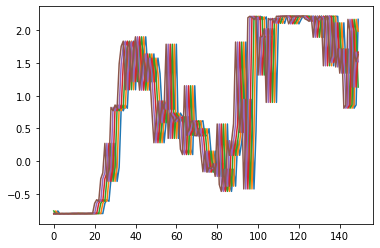

In [210]:
print(Y_train_scaled)
plt.plot(Y_train_scaled[100:250])

In [211]:
# Define an ANN regressor
ANNreg = sklearn.neural_network.MLPRegressor(hidden_layer_sizes = (90,30,15), 
                                                activation = 'tanh', 
                                                max_iter = 250, 
                                                verbose = True, 
                                                learning_rate_init = 0.05, 
                                                batch_size = X_train.shape[0])

In [212]:
ANNreg.fit(X_train_scaled,Y_train_scaled)

Iteration 1, loss = 0.49519198
Iteration 2, loss = 1.01153793
Iteration 3, loss = 1.23135625
Iteration 4, loss = 0.58678832
Iteration 5, loss = 0.51945494
Iteration 6, loss = 0.39365860
Iteration 7, loss = 0.38949743
Iteration 8, loss = 0.34490907
Iteration 9, loss = 0.30863223
Iteration 10, loss = 0.32746816
Iteration 11, loss = 0.35372815
Iteration 12, loss = 0.34668118
Iteration 13, loss = 0.31586547
Iteration 14, loss = 0.29477912
Iteration 15, loss = 0.28722232
Iteration 16, loss = 0.27874961
Iteration 17, loss = 0.27277121
Iteration 18, loss = 0.27203732
Iteration 19, loss = 0.26887941
Iteration 20, loss = 0.26237623
Iteration 21, loss = 0.25029087
Iteration 22, loss = 0.23499379
Iteration 23, loss = 0.22093710
Iteration 24, loss = 0.21494954
Iteration 25, loss = 0.21614761
Iteration 26, loss = 0.21378958
Iteration 27, loss = 0.20878764
Iteration 28, loss = 0.20018080
Iteration 29, loss = 0.19121756
Iteration 30, loss = 0.18566542
Iteration 31, loss = 0.18362206
Iteration 32, los

MLPRegressor(activation='tanh', batch_size=347316,
             hidden_layer_sizes=(90, 30, 15), learning_rate_init=0.05,
             max_iter=250, verbose=True)

In [213]:
ANNreg.score(X_validation_scaled,Y_validation_scaled)

0.7259001976734218

<span style="color:blue"> --> The score is really low indicating that our model is not useful. But we will inspect it a bit more.

In [214]:
Y_pred_scaled = ANNreg.predict(X_validation_scaled)
Y_pred_descaled = Yscaler.inverse_transform(Y_pred_scaled)

In [215]:
Corr_s = []
for i in range(len(Y_pred_scaled[1,:])):
    Corr_s.append(np.corrcoef(Y_pred_scaled[:,i],Y_validation_scaled[:,i]))
Corr_s

[array([[1.        , 0.90974753],
        [0.90974753, 1.        ]]),
 array([[1.        , 0.88717024],
        [0.88717024, 1.        ]]),
 array([[1.        , 0.86260139],
        [0.86260139, 1.        ]]),
 array([[1.        , 0.83833042],
        [0.83833042, 1.        ]]),
 array([[1.        , 0.81521164],
        [0.81521164, 1.        ]]),
 array([[1.        , 0.79466484],
        [0.79466484, 1.        ]])]

<span style="color:blue"> --> The prediction seems fairly ok for only one time step but gets much worse for later timesteps.

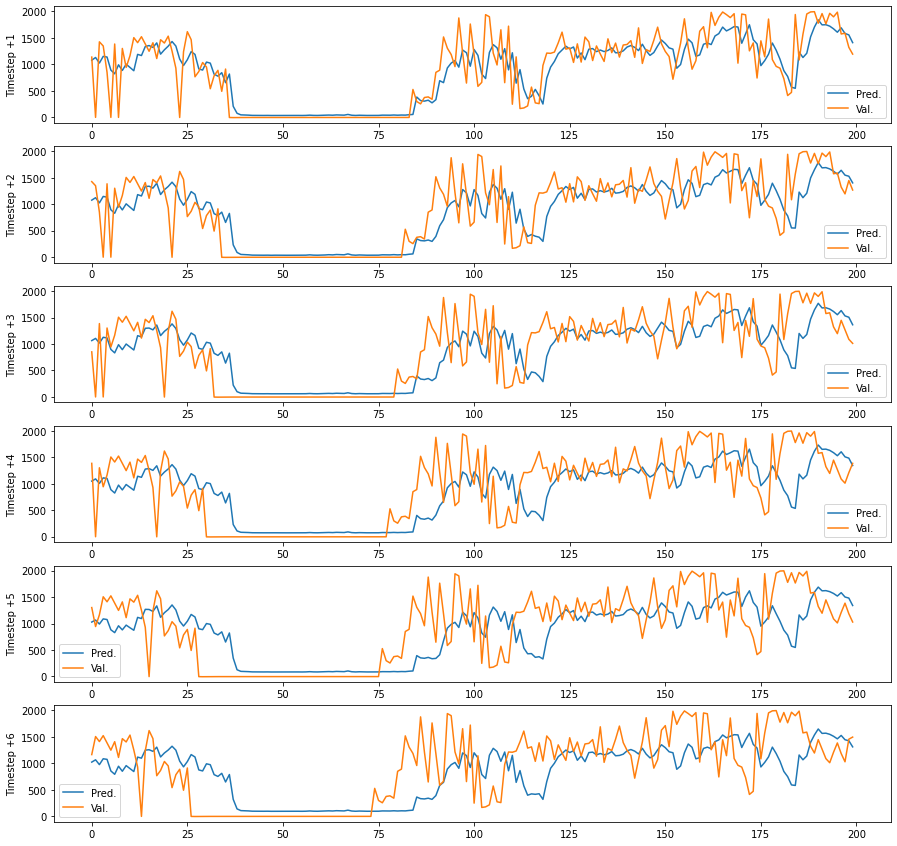

In [217]:
fig,ax = plt.subplots(len(Y_pred_descaled[1,:]),1,figsize=(15,15))

for i in range(len(Y_pred_descaled[1,:])):
    ax[i].plot(Y_pred_descaled[1000:1200,i],label='Pred.')
    ax[i].plot(Y_validation.values[1000+i:1200+i,i],label='Val.')
    ax[i].set_ylabel('Timestep +' + str(i+1))
    ax[i].legend()


##  <span style="color:blue"> Conclusions:
    
  <span style="color:blue"> We could make the ANN MLPRegression model learn and it shows some interesting results. However, it seems not to outperform the persistence model.